In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import dataretrieval as nwis
import matplotlib.pyplot as plt

/opt/miniconda3/lib/python3.9/site-packages/dataretrieval/nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


In [2]:
### Load test data
fields = ['X_00060_00003', 'Date']
df = pd.read_csv('../data/NWIS_streamflow/14362250.csv',usecols=fields)
df.columns = ["time","streamflow_NWIS"]
df['time'] = pd.to_datetime(df['time']).dt.tz_localize(None)
df['water_year'] = df.time.dt.year.where(df.time.dt.month < 10, df.time.dt.year + 1)
# df['water_year'] = df['time'].dt.year 

In [18]:
## Hydroinformatics Data
# import streamstats as sst
# siteno = "02138500"
# startDate = "1922-01-01"
# endDate = "1984-01-01"
# parameter = "00060"

# df = nwis.get_record(site = siteno, service = 'dv', start = startDate, end=endDate)
# df = df.drop(['00060_Mean_cd','site_no'],axis=1)
# df.columns  = ['streamflow_NWIS']
# df['time'] = df.index
# df['time'] = pd.to_datetime(df['time']).dt.tz_localize(None)
# df['water_year'] = df.time.dt.year.where(df.time.dt.month < 10, df.time.dt.year + 1)

In [18]:
# Stibnite
# import streamstats as sst
siteno = "13311000"
startDate = "1980-01-01"
endDate = "2016-01-01"
parameter = "00060"

df = nwis.get_record(site = siteno, service = 'dv', start = startDate, end=endDate,parameterCd = parameter)
df = df.drop(['00060_Mean_cd','site_no'],axis=1)
df.columns  = ['streamflow_NWIS']
df['time'] = df.index
df['time'] = pd.to_datetime(df['time']).dt.tz_localize(None)
df['water_year'] = df.time.dt.year.where(df.time.dt.month < 10, df.time.dt.year + 1)
df

,streamflow_NWIS,time,water_year
datetime,,,
1982-10-01 00:00:00+00:00,17.00,1982-10-01,1983
1982-10-02 00:00:00+00:00,16.00,1982-10-02,1983
1982-10-03 00:00:00+00:00,16.00,1982-10-03,1983
1982-10-04 00:00:00+00:00,17.00,1982-10-04,1983
1982-10-05 00:00:00+00:00,16.00,1982-10-05,1983
...,...,...,...
2015-12-28 00:00:00+00:00,8.14,2015-12-28,2016
2015-12-29 00:00:00+00:00,8.05,2015-12-29,2016
2015-12-30 00:00:00+00:00,7.94,2015-12-30,2016


In [19]:
df['7Q10'] = df['streamflow_NWIS'].rolling(window=7).mean()

In [20]:
lf7q10 = df.groupby(['water_year']).min()
lf7q10 = lf7q10.drop(['time','streamflow_NWIS'],axis=1)
lf7q10 = lf7q10[df['7Q10'].isnull().groupby(df['water_year']).sum() <= 36.6]
lf7q10 = lf7q10[lf7q10['7Q10']>0]

In [21]:
lf7q10["RI"] = (1+len(lf7q10))/lf7q10['7Q10'].rank(method = "min")
lf7q10["ExcProb"] = 1/lf7q10["RI"]

In [22]:
lf7q10

,7Q10,RI,ExcProb
water_year,,,
1983,6.214286,2.750000,0.363636
1984,6.585714,2.200000,0.454545
1985,6.828571,1.833333,0.545455
1986,7.585714,1.571429,0.636364
1987,7.335714,1.692308,0.590909
1988,5.600000,4.400000,0.227273
1989,4.500000,11.000000,0.090909
1990,6.371429,2.444444,0.409091
1991,5.400000,5.500000,0.181818


<AxesSubplot:xlabel='RI', ylabel='7Q10'>

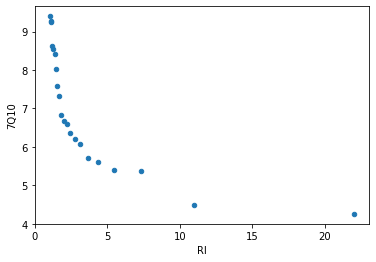

In [23]:
lf7q10.plot.scatter(x="RI",y = "7Q10")

<AxesSubplot:xlabel='ExcProb', ylabel='7Q10'>

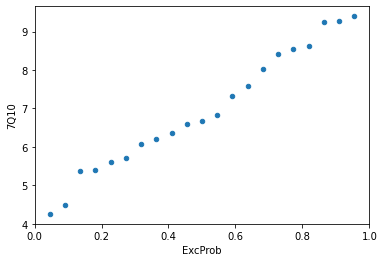

In [24]:
lf7q10.plot.scatter(x="ExcProb",y = "7Q10")

In [25]:
#Measures of the distribution
Xbar = np.mean(np.log10(lf7q10['7Q10']))
S = np.std(np.log10(lf7q10['7Q10']))
g = skew(np.log10(lf7q10['7Q10']))
 
# #calculate z, K, to plot the fitted Pearson Type III
# QyearlyMins <- QyearlyMins %>% 
#   mutate(z = 4.91 * ((1 / ReturnInterval) ^ 0.14 - (1 - 1 / ReturnInterval) ^ 0.14)) %>%
#   mutate(K = (2 / g) * (((1 + (g * z) / 6 - (g ^ 2) / 36) ^ 3) - 1) ) %>%
#   mutate(Qfit = 10^(Xbar + (K * S)))

lf7q10["z"] = 4.91 * ((1 / lf7q10["RI"])**0.14 -(1 - 1 / lf7q10["RI"])**0.14)
lf7q10["K"] = (2/g) * ((((lf7q10["z"] - (g/6))*(g/6)+1)**3)-1)
# lf7q10["K"] = (2/g) * (((1 + (g/lf7q10["z"])/6-(g**2)/36)**3) - 1)
lf7q10["Qfit"] = 10**(Xbar + (lf7q10["K"] * S))

In [26]:
lf7q10

,7Q10,RI,ExcProb,z,K,Qfit
water_year,,,,,,
1983,6.214286,2.750000,0.363636,-0.347309,-0.304651,6.327081
1984,6.585714,2.200000,0.454545,-0.113674,-0.066972,6.679152
1985,6.828571,1.833333,0.545455,0.113674,0.159379,7.032642
1986,7.585714,1.571429,0.636364,0.347309,0.386975,7.406940
1987,7.335714,1.692308,0.590909,0.228883,0.272242,7.215827
1988,5.600000,4.400000,0.227273,-0.745697,-0.721943,5.753247
1989,4.500000,11.000000,0.090909,-1.335085,-1.367586,4.966238
1990,6.371429,2.444444,0.409091,-0.228883,-0.183530,6.504114
1991,5.400000,5.500000,0.181818,-0.906475,-0.894690,5.531207


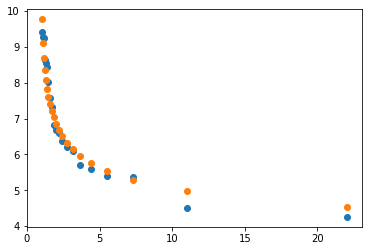

In [27]:
plt.scatter(lf7q10["RI"],lf7q10['7Q10'])
plt.scatter(lf7q10["RI"],lf7q10['Qfit'])

In [29]:
RetIntCalc = 10
z = 4.91 * ((1 / RetIntCalc)**0.14 -(1 - 1 / RetIntCalc)**0.14)
K = (2/g) * ((((z - (g/6))*(g/6)+1)**3)-1)
# K = (2/g) * ((((1 + (g/z))/6-((g**2)/36))**3) - 1)
# PearsonQY= np.exp(Xbar + (K * S))
10**(Xbar + (K * S))

5.0352057926162805